In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Use Case and Innovation

> **Problem Statement**
    - Increased risk, effort, and cost, caused by inadequate process to allocate architects to projects
      
> **Opportunity**
    - Provide project resource estimation for architecture work based on business requirements, skillset, architects allocation, and any other relevant information to enable successful project solution delivery.

> **How GenAI help to solve**
    - Enabling actionable insights to Project Management Office and Enterprise Architecture teams matching initiatives with architects profile.
    - Enhance overall allocation process informing the decision make process
    - Accelerate assessment of best man to the work
    - Increase process efficiency with focus on insight-driven
    - Promote better collaboration between both teams

#### **Enterprise Architecture in the Era of Generative AI**

**Novel** 
    - Democratise enterprise architecture, embracing the power of Generative AI models, transforming traditional IT landscapes into conversational domains enhancing overal Architecture Capability to empower individuals with knowledge, increase efficiency and productivity, accelerate Business Requirement identification and translation to target reference architectures, improve agility, increase collaboration, cost optimisation, enable business growth, and last not least unlock individual potential.<br><br>

**Background**
- The **Architecture Demand Planning** use-case is the latest as part of my exploration journey started about two years ago on how Generative AI impacts Business, Enterprise, and Solution Architectures.

**Aditional Information**
- To learn more head to my HuggingFace space [Talk to your Multi-Agentic Architect Partner](https://huggingface.co/spaces/avfranco/ea4all_agentic_system)

**EA4ALL-Architecture-Demand-Management Architecture Design**<br>
- High-level Architercture descring key components used in this use-case and flow.
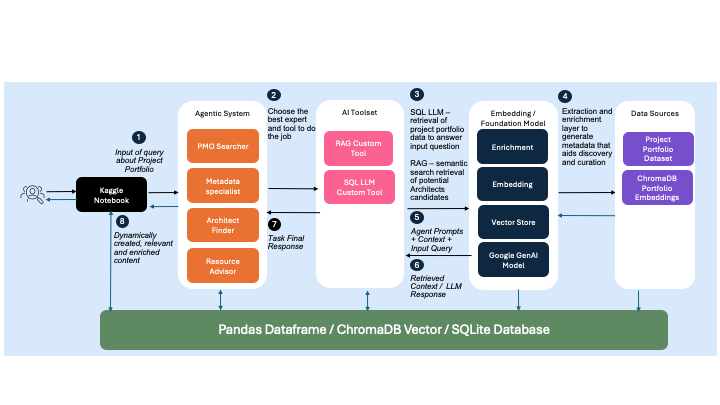

# Instructions

**Running** the EA4ALL-Demand-Planning Agentic System<br>
- GEMINI_API_KEY needs to exist into **Secrets**
- **Run all**
- **Input question**: an example question is given "List two projects without an architect allocated."<br><br>

**Additional Instructions**<br>
  - To expirement with different questions, **uncomment and run the last cell of this notebook** *Play with different questions*

# Notebook Initialisation

> Install libraries<br>
> Load secrets<br>
> Import libraries & classes<br>
> Load project portfolio dataset

In [ ]:
# Filter out Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Install libraries needed to support this use-case: Langchain, ChromaDB
!uv -q pip uninstall --system jupyterlab  # Remove unused conflicting packages
!uv -q pip install --system "google-genai==1.7.0" "chromadb==0.6.3" "protobuf==3.20.3"
!uv -q pip install --system "langchain-google-genai" "langchain_community" "langchain-openai"
!uv -q pip install --system crewai==0.108.0 crewai_tools==0.38.1 opentelemetry-api==1.31.1 opentelemetry-sdk==1.31.1


In [ ]:
# Load secrets
from kaggle_secrets import UserSecretsClient
import os

GEMINI_API_KEY = UserSecretsClient().get_secret("GEMINI_API_KEY")

os.environ['GOOGLE_API_KEY'] = GEMINI_API_KEY
os.environ['GEMINI_API_KEY'] = GEMINI_API_KEY

In [ ]:
# Load dataset with project portfolio entries
# It will later be used to upload a SQL database for Agentic Search
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "./ea4all-portfolio-management.csv"

# Load the latest version
pmo_df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "learnitalldoitall/ea4all-pmo-ds",
  file_path,
)

In [ ]:
# Constant in use

VERBOSE = False #True to show Crew / Agent DEBUG information

# Retrieval augmented generation (RAG) Portfolio Custom Tool 

* **Expertise**: Perform semantic searchs on project portfolio CSV file.</n>
* **Input**: Porfolio question, example, "List all projects with similar architecture requirements."
* **GenAI Capabilities**
  * Structured output/JSON mode
  * Few-shot prompting
  * Retrieval augmented generation (RAG)
  * Vector search/vector store/vector database


In [ ]:
#Init Embeddings via Langchain
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings_fn = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004", google_api_key=GEMINI_API_KEY)

#Use Google Embeddings via ChromaDB
import chromadb.utils.embedding_functions as embedding_functions
google_ef  = embedding_functions.GoogleGenerativeAiEmbeddingFunction(api_key=GEMINI_API_KEY)

#Initialise Google GenAI LLM via Langchain
from langchain_google_genai import GoogleGenerativeAI
llm = GoogleGenerativeAI(model="models/gemini-2-0-flash", temperature=0, google_api_key=GEMINI_API_KEY)

In [ ]:
##Load project portfolio dataframe into Langchain Documents
from langchain_community.document_loaders import DataFrameLoader

loader = DataFrameLoader(pmo_df, page_content_column="Project Name")
documents = loader.load()

In [ ]:
##Init ChromaDB as a Collection
import chromadb

chroma_client = chromadb.Client()
pmo_collection = chroma_client.get_or_create_collection(name= "pmo-capstone")

_docs = []
_metadatas = []
_ids = []
_embeddings = []

for index, row in pmo_df.iterrows():
    output_str = ""
    # Treat each row as a separate chunk
    for col in pmo_df.columns:
        output_str += f"{col}: {row[col]},\n"

    _embeddings.append(embeddings_fn.embed_query(output_str))
    _docs.append(output_str)
    _metadatas.append(
        {
            "project_name": row['Project Name'],
            "lob": row['Line of Business'],
            "business_problem": row['Problem Statement'],
            "status": row['Status'],
            "planned-start": row['Timeline - Start'],
            "planned-end": row['Timeline - End'],
            "architect": row['Architect'],
        },
    )
    _ids.append(f"id{index}")

pmo_collection.add(
    documents=_docs,
    metadatas=_metadatas,
    embeddings=_embeddings,
    ids=_ids
)


In [ ]:
from crewai.tools import BaseTool

from pydantic import BaseModel, Field
from typing import Optional, List, Any, Type, Dict
import json

# Tool Input Schema
class RAGInputTool(BaseModel):
    """Input schema for RAGPortfolioTool."""
    query: str = Field(..., description="Project portfolio query.")

#Define the Tool structured-output model
class ProjectDetails(BaseModel):
    """Project Information"""
    project_name: str = Field(description="Project name.")
    project_lob: str = Field(description="Responsible line of business")
    business_problem: str = Field(description="Business problem description.")
    project_status: str = Field(description="Project status")
    planned_start: Optional[str] = Field(default=None, description="Project planned start date")
    planned_end: Optional[str] = Field(default=None,description="Project planned end date")
    architect: Optional[str] = Field(description="Architect for this project")

#Main Custom Tool class
class RAGPortfolioTool(BaseTool):
    """A tool for querying a project portfolio CSV file."""
    
    name: str = "RAG Project Portfolio Custom Tool"
    description: str = ("Perform Semantic search on the project portfolio to answer a given question.")
    
    args_schema: Type[BaseModel] = RAGInputTool

    def _run(self, query:str) -> Any:
        
        if VERBOSE:
            print(f"### DEBUG ### User Query: {query}\n\n")

        query_results = pmo_collection.query(
            query_embeddings=embeddings_fn.embed_query(query),
            n_results=5
        )

        json_data = []
        for row in range(len(query_results['ids'][0])):
          json_data.append({
            "project_name": query_results['metadatas'][0][row]['project_name'],
            "business_problem": query_results['metadatas'][0][row]['business_problem'],
            "lob": query_results['metadatas'][0][row]['lob'],
            "status": query_results['metadatas'][0][row]['status'],
            "planned_start": query_results['metadatas'][0][row].get('planned-start', 'No planned start date'),
            "planned_end": query_results['metadatas'][0][row].get('planned-end', 'No planned end date'),
            "architect": query_results['metadatas'][0][row].get('architect',''),
            "distance": query_results['distances'][0][row]
            }
        )

        return str(json_data)


# SQLite Portfolio Custom Tool 

* **Expertise**: Transform Text to SQL statement and query execution on the project portfolio SQLite database.</n>
* **Input**
  * Text: Porfolio question, example, "List all projects with no architect assigned"
  * SQL Query: select * from table where architect is NULL</n>
* **GenAI Capabilities**
  * Function Calling
  * Structured output/JSON mode
  * Few-shot prompting
  * Text to SQL search


In [ ]:
"""Initialise the SQLite Portfolio Database."""
from langchain_community.utilities import SQLDatabase
from sqlalchemy import create_engine, inspect

DB_PATH = "sqlite:///Chinook.db"
ea4all_db = SQLDatabase.from_uri(DB_PATH)
engine = create_engine(DB_PATH)

try:
    pmo_df.to_sql('pmo_capstone', engine, index=False)
except Exception as e:
    pass


In [ ]:
# BUILD the custom tool SQLitePortfolioTool to be used by the CrewAI Portfolio Agent.
from google import genai
from google.api_core import retry
from google.genai import types

from crewai.tools import BaseTool

from pydantic import BaseModel, Field
from typing import Optional, List, Any, Type

# Init Google GenAI client
client = genai.Client(api_key=GEMINI_API_KEY)

# Tool Input Schema
class SQLiteAgentInput(BaseModel):
    """Input schema for SQLitePortfolioTool."""
    query: str = Field(..., description="Project portfolio user's query.")

#Define the Tool structured-output model
class ProjectDetails(BaseModel):
    """Project Information"""
    project_name: str = Field(description="Project name.")
    project_lob: str = Field(description="Responsible line of business")
    business_problem: str = Field(description="Business problem description.")
    project_status: str = Field(description="Project status")
    planned_start: Optional[str] = Field(default=None, description="Project planned start date")
    planned_end: Optional[str] = Field(default=None,description="Project planned end date")

class ProjectList(BaseModel):
    """List of Projects"""
    projects: List[ProjectDetails] = Field(...,description="List of projects")

#Define Tools to be used by the SQL LLM
def list_tables() -> list[str]:
    """Retrieve the names of all tables in the database.

    Returns:
        A list with table names
    """
    
    # Include print logging statements so you can see when functions are being called.
    print(' - DB CALL: list_tables')

    # Fetch the table names.
    tables = ea4all_db.run("SELECT name FROM sqlite_master WHERE type='table';")

    return tables

def describe_table(table_name: str) -> list[tuple[str, str]]:
    """Look up the table schema.

    Returns:
      List of columns, where each entry is a tuple of (column, type).
    """
    print(' - DB CALL: describe_table')

    schema = ea4all_db.run(f"PRAGMA table_info({table_name});")

    return schema


def execute_query(sql: str) -> list[list[str]]:
    """Execute a SELECT statement, returning the results.
   
    Returns:
      List of results, where each entry is a list of text 
    """
    
    print(' - DB CALL: execute_query')

    result = ea4all_db.run(sql)
    return result

# Define main Tool Class
class SQLitePortfolioTool(BaseTool):
    """A tool for querying a project portfolio SQLite database."""
    
    name: str = "SQLite Project Portfolio Custom Tool"
    description: str = ("Perform SQL queries on the project portfolio SQLite database to answer user's question.")
    
    args_schema: Type[BaseModel] = SQLiteAgentInput

    def _run(self, query:str):

        if VERBOSE:
            print(f"### DEBUG ### User Query: {query}\n\n")
    
        # These are the Python functions defined above.
        db_tools = [list_tables, describe_table, execute_query]
        
        # Define a retry policy. The model might make multiple consecutive calls automatically
        # for a complex query, this ensures the client retries if it hits quota limits.
        retry_policy = {"retry": retry.Retry(predicate=retry.if_transient_error)}
        
        instruction = """You are a helpful project portfolio specialist that can interact with an SQL database to answer user's projects question. 
        You will take the users questions and turn them into SQL queries using the tools available. 
        Once you have the information you need, you will answer the user's question using the data returned. 
        Use list_tables to see what tables are present, describe_table to understand the schema, and execute_query to issue an SQL SELECT query.
        
        Examples:
        Question-1: List all projects in progress.
        SQL Query-1: select * from pmo_capstone where Status = 'In Flight'.

        Question-2: List all project with no architects allocated.
        SQL Query-2: select * from pmo_capstone where architect is NULL
        """
        
         # Configure the client and tools
        config = types.GenerateContentConfig(
            tools=db_tools,
            system_instruction=instruction,
            temperature=0,
        )
        
        #Add structured query to user's question
        structured_query = """
            Retrieve project details with these exact requirements:
            - Return a JSON array of project objects
            - Each object must have these EXACT keys:
              1. "project_name"
              2. "project_lob"
              3. "business_problem"
              4. "project_status"
              5. "planned_start"
              6. "planned_end"
            - You must always return valid JSON fenced by a markdown code block. Do not return any additional text.
            - Do NOT fabricate data
            - If no data matches, return an empty array"""
        
        final_input = f"{query}\n\n{structured_query}" 
        
        # Send request with function declarations
        response = client.models.generate_content(
            model="gemini-2.5-flash-preview-04-17", #"gemini-1.5-pro-latest"
            contents=final_input,
            config=config,
        )
        
        return response.text


# Architecture Demand Management Agentic System

* **Expertise**:
  * Retrieve initiative details from the project portfolio
  * Extract skills, experience, education, and architecture requirements
  * Find the most appropriate Architects to do the job
  * Summarise a report with recommendation<br><br>
* **Input**: Porfolio question, example, "List all projects with no architect assigned"<br><br>
* **GenAI Capabilities**
  * Agents
  * Structured output/JSON mode/controlled generation
  * Few-shot prompting
  * Function Calling
  * Text to SQL search
  * Embeddings
  * Retrieval augmented generation (RAG)
  * Vector search/vector store/vector database


In [ ]:
#Import CrewAI libraries
from crewai import Agent, Crew, Process, Task, LLM
from crewai.project import CrewBase, agent, crew, task

In [ ]:
#Set up Crew
from pydantic import BaseModel, Field
from typing import List, Dict
    
crew_model = LLM(
    model="gemini/gemini-2.0-flash",
    temperature=0.0,
    top_p=0.1,
    top_k=10,
    stop=["END"],
    api_key=GEMINI_API_KEY,
)

pmo_source = SQLitePortfolioTool(result_as_answer=True)
rag_source = RAGPortfolioTool(result_as_answer=True)

class ProjectQualification(BaseModel):
    """Project Qualification"""
    project_name: str = Field(description="Project name.")
    skills: List[str] = Field(description="Skills needed for this project", default_factory=list)
    experience: List[str] = Field(description="Experience needed for this project", default_factory=list)
    education: List[str] = Field(description="Education needed for this project", default_factory=list)
    requirements: List[str] = Field(description="Architecture requirements for this proejct", default_factory=list)
    
class QualificationList(BaseModel):
    """List of Projects"""
    qualification: List[ProjectQualification] = Field(...,description="Qualifications for project.")

class ArchitectExperience(BaseModel):
    """Architects Project Experience"""
    architect_name: str = Field(description="Architect name")
    past_project: List[str] = Field(description="Project with similar requirements.", default_factory=list)
    work_experience: List[str] = Field(description="Previous work experience.", default_factory=list)
    
class ArchitectList(BaseModel):
    """List of potential architects with necessary skills and experience to work on new project"""
    project_name: str = Field(...,description="Project name")
    candidate: List[ArchitectExperience] = Field(...,description="Architects Candidate for projects.")

    
class AgentPMO:
    search_pmo = Agent(
        role="Project Portfolio Specialist",
        goal="Answer questions about project portfolio using the available tool.",
        backstory="You excel on project portfolio question-answering with more than 20 years managing project portfolio tasks.",
        verbose=VERBOSE,
        max_iter=5,
        tools=[pmo_source],
        llm=crew_model
    )
        
    search_pmo_task = Task(
        name="search_pmo_task",
        description="Answer projects portfolio questions to the best of your ability. Use the available tool to help you."
        "Provide as input to the tool the original user question. Do not change it."
        "Do not answer questions that are not related to project portfolio content. Question: {question}",
        expected_output="JSON array of project objects with keys: project_name,project_lob,business_problem,project_status,planned_start,planned_end",
        verbose=True,
        agent=search_pmo,
        tools=[pmo_source],
    )

    parse_project = Agent(
        role="Project Portfolio Interpreter",
        goal= "Extract relevant information from the project, such as skills, experience, education, and architecture requirements.",
        backstory= "With years of experience in Enterprise Architecture and Project Portfolio Management, you excel at quickly identifying key architecture qualifications and requirements to succesfully allocate the best architect to the job.",
        verbose=VERBOSE,
        max_iter=3,
        llm=crew_model
    )

    parse_project_task = Task (
        name="parse_project_task",
        description="Based on the context you got, extract relevant information from the given project."
        "Focus on skills, experience, education, and architecture requirements, needed by a solution architect to deliver the project solution design.",
        expected_output="JSON array of resource requirements with keys: project_name, problem_statement, skill,experience, education, and architecture_requirements.",
        verbose=VERBOSE,
        agent=parse_project,
        context=[search_pmo_task]
    )

    architect_candidate = Agent(
        role="Project Portfolio Architect Finder",
        goal= "Identify architects with work experience and skills for new projects.",
        backstory= "With years of experience in Enterprise Architecture and Project Portfolio Management, you excel at quickly identifying potential architects to work on projects, based on project's skills, experience, education, and architecture requirements.",
        verbose=VERBOSE,
        max_iter=3,
        llm=crew_model,
        tools=[rag_source],
        context=[parse_project_task]
    )
 
    architect_candidate_task = Task (
        name="parse_project_task",
        description="Based on the context you got, match the list of architecture requirements you got to other projects in the portfolio."
        "Evaluate how similar the architecture requirement is to the other projects."
        "Architecture requirements don't need to be exactly the same but similar."
        "Project must have an architect assigned.",
        expected_output="""List of projects with similar architecture requirements, with these exact details:
            - Return a JSON array of project objects
            - Each object must have these EXACT keys:
              1. "project_name"
              2. "business_problem"
              3. "architect"
              4. "project_status"
            - You must always return valid JSON fenced by a markdown code block. Do not return any additional text.
            - Do NOT fabricate data
            - If no data matches, return an empty array""",
        verbose=VERBOSE,
        agent=architect_candidate,
    )

    resource_advisor = Agent (
        role="Project Portfolio Resource Advisor",
        goal= "Compile all gathered information into a concise, informative briefing report",
        backstory= "As the Resource Advisor, your role is to consolidate the analysis, and product a final report.",
        verbose=VERBOSE,
        max_iter=3,
        llm=crew_model,
        context=[architect_candidate_task]
    )

    resource_advisor_task = Task (
        name="resource_advisor_task",
        description="Based on the context you got, summarise in a compelling way the recommend architects for each project.",
        expected_output="A markdown text include title, business problem, skillset, experience, architecture requirements, and recommended architect. ",
        verbose=VERBOSE,
        agent=resource_advisor
    )

    pmo_crew = Crew(
        agents=[search_pmo, parse_project, architect_candidate, resource_advisor],
        tasks=[search_pmo_task, parse_project_task, architect_candidate_task, resource_advisor_task],
        process=Process.sequential,
        verbose=VERBOSE,
        llm=crew_model,
    )

# EA4ALL-Demand-Planning Execution

**Instruction for running** the EA4ALL-Demand-Planning Agentic System<br>
- GEMINI_API_KEY needs to exist into **Secrets**
- Make sure to **run before** cells
- **Input question**: an example question is given "List two projects without an architect allocated."<br><br>

**Additional Instructions**<br>
  - To expirement with different questions, **run the last cell of this notebook** *Play with different questions*<br><br>

In [ ]:
#PMO-Portfolio-Crew-Agent 
from IPython.display import Markdown

#RUN Agentic System Crew
def run(question):
    """
    Run the crew.
    """
    try:
        inputs = {
            "question": question,
        }
        
        result = AgentPMO().pmo_crew.kickoff(inputs=inputs)
            
    except Exception as e:
        raise Exception(f"An error occurred while running the crew: {e}")

    return result

#INPUT sample question & run
question = "List two projects with no architects."
pmo_crew_output = run(question)

# Display final recommendation report with potential candidate architects
Markdown(pmo_crew_output.raw)

In [ ]:
# Play with different questions
# Remove """ to run with other questions

"""
while True:
    question = input("Enter a question about your Project Portfolio or /bye to finish:")
    if question == '/bye':
        print("Thank you!")
        break
    else:
        pmo_crew_output = run(question)
"""